In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import xarray as xr
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm

## For google colab

In [3]:
# Load the Drive helper and mount
#from google.colab import drive
#drive.mount('/content/drive')
#path = 'drive/MyDrive/SUP/4A/SDD/hackaton_ocean/ocean-eddy-detection'

# Pre-processing

In [1]:
from torchvision import datasets, transforms

image_transforms = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(1.0),
        transforms.RandomVerticalFlip(1.0),
        transforms.GaussianBlur(7, sigma=(0.1, 3.0)),
    ]
)

In [2]:
class TrainDataset():
    def __init__(self, path):

        eddies_train = xr.open_dataset(path + '/eddies_train.nc')
        X_train = xr.open_dataset(path + '/OSSE_U_V_SLA_SST_train.nc')
        
        y = eddies_train.eddies.values
        
        X_verti = X_train.vomecrtyT.values
        X_hori = X_train.vozocrtxT.values
        X_SSH = X_train.sossheig.values
        X_SST = X_train.votemper.values
        
        ##Transformation
        X = np.array([X_verti, X_hori, X_SSH, X_SST])
        X = X.transpose((1,0,2,3))
        
        y = np.nan_to_num(y, nan=3)
            
        #Enregistre les index correspondant aux bords
        edges_index = []
        for i in range(1,X.shape[2]-1):
            for j in range (1,X.shape[3]-1):
                if np.isnan(X[32, 3, i, j]):
                    if np.any(np.isnan(X[32, 3, i-1:i+2, j-1:j+2])!=True):
                        edges_index.append((i, j))  
        
        
        for img_index in tqdm(range(X.shape[0])):
            for index in edges_index:
                i, j = index
                X[img_index, :, i, j] = np.mean(X[img_index, :, i-1:i+2, j-1:j+2], axis=(1,2))

        
        X = np.nan_to_num(X, nan=0)
    
        ##Normalisation
        
        X = (X - np.min(X, axis=(0,2,3), keepdims=True))/( np.max(X, axis=(0,2,3), keepdims=True) - np.min(X, axis=(0,2,3), keepdims=True) )
        
        ##Augmentation 
        
        X = torch.tensor(X)
        y = torch.tensor(y, dtype=torch.long).reshape(y.shape[0],1, y.shape[1],y.shape[2])
        data = torch.cat((X,y),dim=1)
        
        data_aug = image_transforms(data)
        
        X_aug  = data_aug[:,:-1,:,:]
        y_aug = data_aug[:,-1,:,:]
        
        self.X_train = torch.cat((X, X_aug), dim=0)
        self.y_train = torch.cat((y.reshape(y.shape[0], y.shape[2], y.shape[3]), y_aug), dim=0)
        self.image_transforms = image_transforms
        
        #X = torch.tensor(X)
        #y = torch.tensor(y, dtype=torch.long)
        
        #self.X_train = X
        #self.y_train = y       
        
        
    def __len__(self):
        return len(self.X_train)

    def __getitem__(self, idx):
        return self.X_train[idx], self.y_train[idx]


In [ ]:
class TestDataSet():

    def __init__(self, path):
        self.X_test = xr.open_dataset(path + '/OSSE_U_V_SLA_SST_test.nc')
    
    def __len__(self):
        return len(self.X_test)
    
    def __getitem__(self, idx):
        return self.X_test[idx]


We split the set between one train set and one validation set.

In [ ]:
from torch.utils.data import random_split

path = 'ocean-eddy-detection/' # local
dataset = TrainDataset(path)

trainDataSet, valDataSet = random_split(dataset, [0.8, 0.2])
trainDataLoader = DataLoader(trainDataSet, batch_size=6, shuffle=True)
valDataLoader = DataLoader(valDataSet, batch_size=2, shuffle=True)

print("The length of train data is:",len(trainDataSet))
print("The length of validation data is:",len(valDataSet))

In [7]:
iterator_data = iter(trainDataLoader)

torch.Size([1, 4, 357, 717])


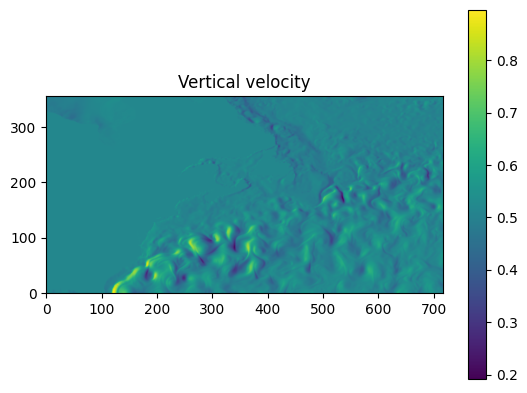

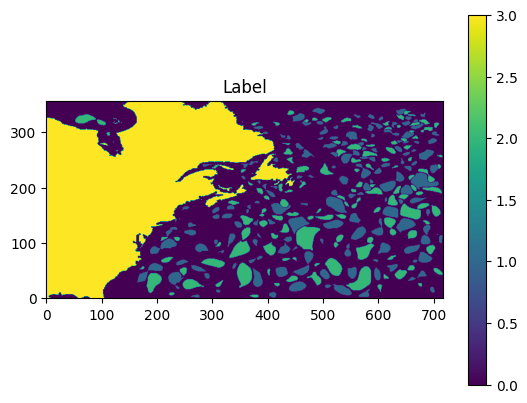

In [8]:
img, label = next(iterator_data)
print(img.shape)
plt.imshow(img[0][0], origin='lower')
plt.colorbar()
plt.title('Vertical velocity')
plt.show()
plt.imshow(label[0], origin='lower')
plt.colorbar()
plt.title('Label')
plt.show()

# Model

In [9]:
class Unet(nn.Module):
    """
    Our modified Unet :
    Use of padding to keep size of input in output easily.
    Use of batchnorm2d after Conv2d
    """
    def __init__(self):
        super().__init__()

        self.downblock1 = nn.Sequential(
            # nn.Dropout2d(0.2),
            nn.Conv2d(4, 64, kernel_size=3, padding='same', padding_mode='replicate'),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding='same', padding_mode='replicate'),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.downblock2 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2),
            # nn.Dropout2d(0.2),
            nn.Conv2d(64, 128, kernel_size=3, padding='same', padding_mode='replicate'),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding='same', padding_mode='replicate'),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.downblock3 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2),
            # nn.Dropout2d(0.2),          
            nn.Conv2d(128, 256, kernel_size=3, padding='same', padding_mode='replicate'),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding='same', padding_mode='replicate'),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        self.middleU = nn.Sequential(
            nn.MaxPool2d(kernel_size=2),
            # nn.Dropout2d(0.2),
            nn.Conv2d(256, 512, kernel_size=3, padding='same', padding_mode='replicate'),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding='same', padding_mode='replicate'),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            # nn.Dropout2d(0.2),
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2)
        )

        self.upblock1 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding='same', padding_mode='replicate'),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding='same', padding_mode='replicate'),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            # nn.Dropout2d(0.2),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        )

        self.upblock2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding='same', padding_mode='replicate'),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding='same', padding_mode='replicate'),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            # nn.Dropout2d(0.2),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2)
        )

        self.upblock3 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding='same', padding_mode='replicate'),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding='same', padding_mode='replicate'),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 3, kernel_size=1)
        )
    

    def forward(self, x):
        
        x1 = self.downblock1(x)

        x2 = self.downblock2(x1)

        x3 = self.downblock3(x2)

        xmiddle = self.middleU(x3)

        xup0_1 = torch.cat((x3,xmiddle), dim=1)
        xup1 = self.upblock1(xup0_1)

        xup1_2 = torch.cat((x2,xup1), dim=1)
        xup2 = self.upblock2(xup1_2)

        xup2_3 = torch.cat((x1,xup2), dim=1)
        xup3 = self.upblock3(xup2_3)

        return xup3


In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class Adapted_loss(nn.Module):
    def __init__(self):
        super().__init__()

        self.loss = nn.CrossEntropyLoss(weight=torch.Tensor([1/13, 6/13, 6/13]))
      
    def forward(self, prediction, target):
        mask = target[0]!=3
        y = target[:,mask]
        ypred = prediction[:,:,mask]
        return self.loss(ypred, y)

#EXEMPLE
#loss = Adapted_loss()
#loss(ypred, y)

# Training

In [11]:
def train_loop(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Move input and target tensors to the device
        X, y = X.to(device), y.to(device)

        # Compute prediction and loss
        pred = model(X)
        #pred = pred.to(dtype=torch.float64)
    
        loss = loss_fn(pred, y.long())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print loss and accuracy
        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


In [ ]:
def val_loop(dataloader, model, loss_fn, device):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X).to(device)
            pred = pred.to(dtype=torch.float64)
            test_loss += loss_fn(pred, y.long()).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
model = Unet()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)
loss_fn = Adapted_loss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-2)

cuda:0


In [ ]:
epochs = 3
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(trainDataLoader, model, loss_fn, optimizer, device)
    val_loop(valDataLoader, model, loss_fn, device)
print("Done!")

Epoch 1
-------------------------------
loss: 1.157507  [    0/  284]
loss: 1.081248  [   10/  284]
loss: 1.050765  [   20/  284]
loss: 0.980220  [   30/  284]
loss: 0.847839  [   40/  284]
loss: 0.824623  [   50/  284]
loss: 0.847146  [   60/  284]
loss: 0.823686  [   70/  284]
loss: 0.778471  [   80/  284]
loss: 0.750627  [   90/  284]
loss: 0.759139  [  100/  284]
loss: 0.727576  [  110/  284]
loss: 0.668971  [  120/  284]
loss: 0.740034  [  130/  284]
loss: 0.716761  [  140/  284]
loss: 0.691338  [  150/  284]
loss: 0.707227  [  160/  284]
loss: 0.690225  [  170/  284]
loss: 0.727302  [  180/  284]
loss: 0.698507  [  190/  284]
loss: 0.730290  [  200/  284]
loss: 0.684581  [  210/  284]
loss: 0.706213  [  220/  284]
loss: 0.665327  [  230/  284]
loss: 0.666559  [  240/  284]
loss: 0.715777  [  250/  284]
loss: 0.681624  [  260/  284]
loss: 0.685152  [  270/  284]
loss: 0.654761  [  280/  284]
Epoch 2
-------------------------------
loss: 0.682587  [    0/  284]
loss: 0.624903  [   

In [ ]:
x_test, label_test = next(iter(valDataLoader))

print(label_test.shape)
x_test = x_test.to(device)[0]
plt.imshow(label_test[0], origin='lower')
plt.show()
plt.imshow(np.argmax(model(x_test.reshape(1,4,357,717)).softmax(dim=1).cpu().detach().numpy(), axis=1)[0], origin='lower')